<a href="https://colab.research.google.com/github/Oksana0020/DL-with-PyTorch/blob/main/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Prepare Sequential Data

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
# Simulated sine wave data
time_steps = 1000
x = np.linspace(0, 50, time_steps)

data = np.sin(x) + 0.1 * np.random.randn(time_steps)


# --------------------------------
# Create sequences for LSTM
# --------------------------------
def create_sequences(data, seq_length):
    """
    Transform a time series into sequences for LSTM processing
    """
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]

        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)


# Sequence length
seq_length = 20


# Create sequences
X, y = create_sequences(data, seq_length)


# --------------------------------
# Train / Test split (80/20)
# --------------------------------
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# --------------------------------
# Convert to PyTorch tensors
# --------------------------------
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)  # (samples, seq_len, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


# --------------------------------
# Dataset class
# --------------------------------
class TimeSeriesDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# --------------------------------
# DataLoaders
# --------------------------------
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# --------------------------------
# Check shapes
# --------------------------------
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: torch.Size([784, 20, 1])
y_train shape: torch.Size([784])


In [8]:
import torch
import torch.nn as nn


In [9]:
# Task 2: Design the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialize LSTM model architecture
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the network
        """
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get output from the last time step
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model with appropriate parameters
input_size = 1  # Single feature (univariate time series)
hidden_size = 64  # Size of LSTM hidden units
num_layers = 2  # Number of stacked LSTM layers
output_size = 1  # Single output (next value prediction)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt


Epoch [10/100], Loss: 0.0119
Epoch [20/100], Loss: 0.0112
Epoch [30/100], Loss: 0.0118
Epoch [40/100], Loss: 0.0111
Epoch [50/100], Loss: 0.0108
Epoch [60/100], Loss: 0.0110
Epoch [70/100], Loss: 0.0110
Epoch [80/100], Loss: 0.0106
Epoch [90/100], Loss: 0.0098
Epoch [100/100], Loss: 0.0105


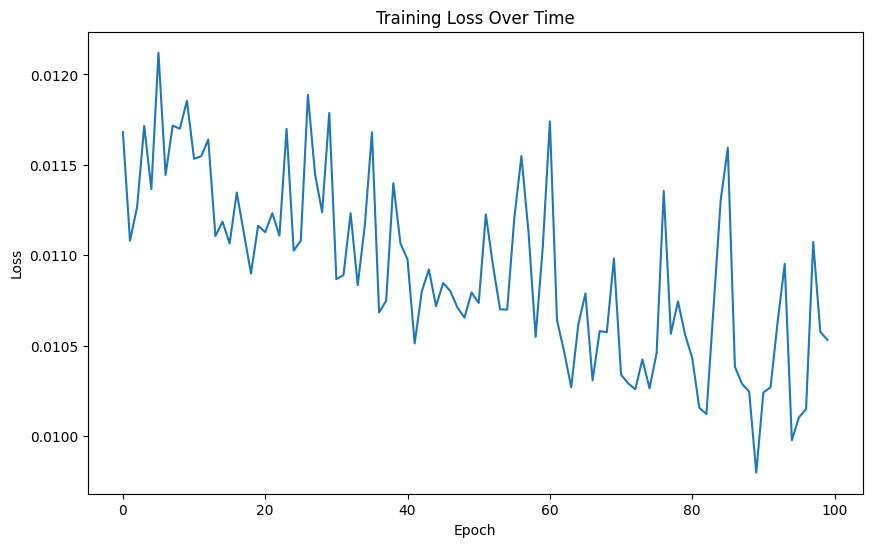

In [14]:
# Task 3: Train the LSTM Model

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set training parameters
num_epochs = 100
batch_size = 32

# Initialize lists to store metrics
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Track training progress
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

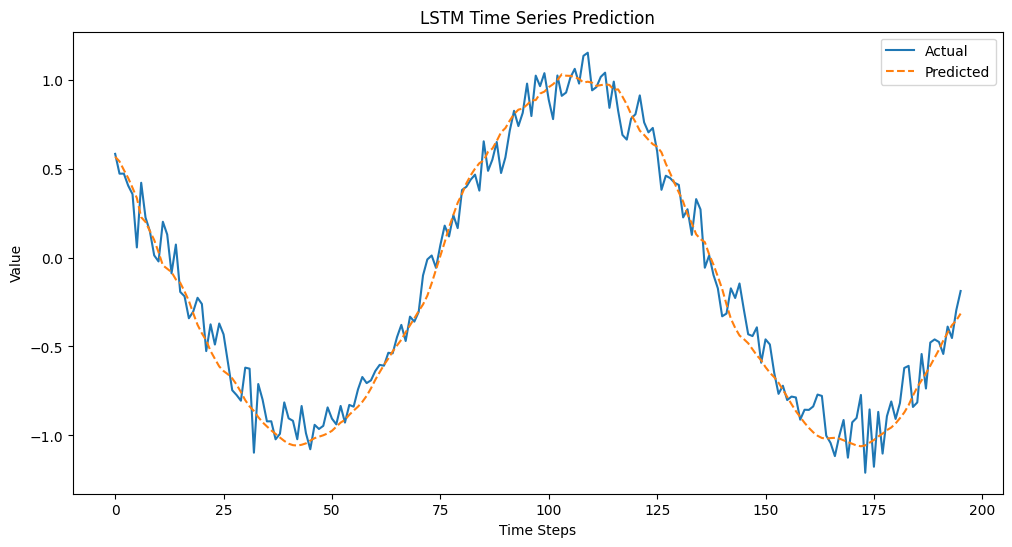

Test MSE: 0.0136
Test MAE: 0.0933


In [15]:
# Task 4: Evaluate and Visualize Predictions

# Set model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    test_predictions = []
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.append(outputs.numpy())

    # Flatten the predictions list
    test_predictions = np.concatenate(test_predictions).flatten()

# Convert tensors to numpy arrays
actual_values = y_test.numpy()

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual')
plt.plot(test_predictions, label='Predicted', linestyle='--')
plt.title('LSTM Time Series Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate error metrics
mse = np.mean((test_predictions - actual_values) ** 2)
mae = np.mean(np.abs(test_predictions - actual_values))
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')